In [1]:
import sys

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/ivectors', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
import os.path
import wave
from collections import Counter
import config
import random
from python_speech_features import mfcc, delta
import scipy.io.wavfile as wav
from spafe.utils import vis
import matplotlib.pyplot as plt
import misc.vad as vad
from sklearn.mixture import GaussianMixture, _gaussian_mixture
reload(vad)
import numpy as np
from scipy.special import logsumexp
from collections import Counter
import helper_functions as hf
reload(hf)
import pickle
import contextlib

In [3]:
# create ads
# female ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/FEMALE/MIC"
female_ads = myads.AudioDatastore()
female_ads.populate(datasetFolder,include_sub_folders=True, label_source=True)
Counter(female_ads.labels).values()
# male ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/MALE/MIC"
male_ads = myads.AudioDatastore()
male_ads.populate(datasetFolder,include_sub_folders=True, label_source=True)
Counter(male_ads.labels).values()
# combine ads
ads = myads.AudioDatastore()
ads.set([datasetFolder], files=female_ads.files + male_ads.files, labels=female_ads.labels+male_ads.labels)

In [4]:
# split ads
developmentLabels = ["M01","M02","M03","M04","M06","M07","M08","M09","F01","F02","F03","F04","F06","F07","F08","F09"]
evaluationLabels = ["M05","M10","F05","F10"]
adsTrain = myads.subset(ads, developmentLabels)
adsEvaluate = myads.subset(ads, evaluationLabels)
numFilesPerSpeakerForEnrollment = 3
adsEnroll, adsDet = myads.split(adsEvaluate, 3)
adsTest, adsDet = myads.split(adsDet, 2)

In [5]:
import utils as my_utils
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import librosa
# sound, _ = librosa.load(adsTest.files[0], sr=16000)
# plt.plot(sound)

In [6]:
fs, sound02 = wav.read(adsTest.files[0])
# plt.plot(sound02)

In [14]:
# test vad
import torch
torch.set_num_threads(1)

In [8]:
torch.hub.download_url_to_file('https://models.silero.ai/vad_models/en.wav', 'en_example.wav')

100.0%


In [9]:
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /Users/david/.cache/torch/hub/master.zip


In [15]:
(get_speech_timestamps,
 _, read_audio,
 *_) = utils

In [22]:
speech_timestamps = get_speech_timestamps(sound, model, sampling_rate=16000)
start = speech_timestamps[0]['start']
end = speech_timestamps[0]['end']

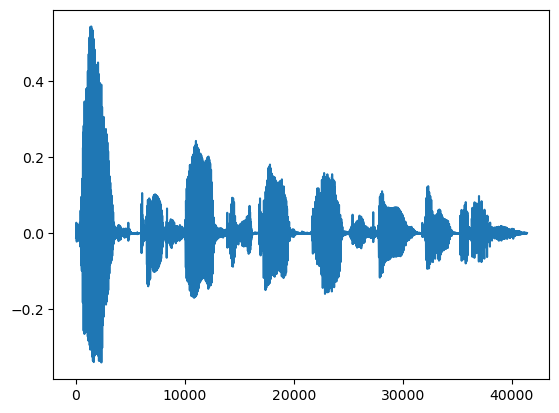

In [23]:
plt.plot(
    sound[start:end])

In [12]:
def write_wave(path, audio, sample_rate):
    """Writes a .wav file.

    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)

In [16]:
for i, segment in enumerate(segments):
    path = 'chunk-%002d.wav' % (i,)
    print(' Writing %s' % (path,))
    write_wave(path, segment, config.SAMPLE_RATE)

1111111111+(0.0)1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111-(3.929999999999989)
 Writing chunk-00.wav


In [10]:
amount = 0
for i, segment in enumerate(segments):
    amount = amount + 1

In [8]:
config.SAMPLE_RATE

16000

In [15]:
speedUpExamples = True
if speedUpExamples:
    adsTrain, _ = myads.split(adsTrain, 10)
    adsDet, _ = myads.split(adsDet, 7)

In [16]:
# set sample rate,
fs, _ = wav.read(adsTrain.files[0])

In [17]:
reload = False

try:
    if reload :
        raise Exception('reloading')
    training_features = pickle.load(open('training_features.pickle','rb'))
except:
    zero_indices = []
    training_features = []
    for i in range(len(adsTrain.files)):
        if i%50 == 0:
            print('completed ' + str(i) + ' iterations')
        feat = hf.helper_feature_extraction(adsTrain.files[i])
        training_features.append(feat)
    print('completed training feature fe!')
    pickle.dump(training_features, open('training_features.pickle','wb'))

completed 0 iterations
completed 50 iterations
completed 100 iterations
completed 150 iterations
completed training feature fe!


In [18]:
# remove [] vectors in training files and pop the file from ads
adsTrainCleaned, training_features_cleaned = myads.clean_zeros(adsTrain, training_features)

In [19]:
# collect normalization factors

import numpy as np
means = []
std = []
for feature in training_features_cleaned:
    if len(feature) > 0:
        means.append(np.mean(feature, axis=0))
        std.append(np.std(feature, axis=0))

means = np.array(means)
means = np.mean(means, axis=0)

std = np.array(std)
std = np.mean(std, axis=0)

class NormFactor:
  def __init__(self, m, s):
    self.means = m
    self.std = s

normFactors = NormFactor(means, std)

pickle.dump(normFactors, open('normFactors.pickle','wb'))

In [20]:
normalised_features = []

for i in range(len(training_features_cleaned)):
    normalised = (training_features_cleaned[i] - means) / std
    normalised = normalised - np.mean(normalised)
    normalised_features.append(normalised)
pickle.dump(normalised_features, open('normalised_features.pickle','wb'))

In [21]:
# train ubm
numComponents = 32
ubm = GaussianMixture(n_components=numComponents, covariance_type='diag')
train_features_flattened = np.array([item for sublist in normalised_features for item in sublist])
ubm.fit(train_features_flattened)
print('sklearn model ll = ' + str(ubm.score(normalised_features[0])))
# pickle.dump(ubm, open('ubm.pickle','wb'))

sklearn model ll = -28.237638693823634


In [22]:
# load
# ubm = pickle.load(open('ubm.pickle', 'rb'))
# normFactors = pickle.load(open('normFactors.pickle','rb'))
# normalised_features = pickle.load(open('normalised_features.pickle','rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'ubm.pickle'

In [12]:
for i in normalised_features:
    if len(i) == 0:
        print('sad face')

In [30]:
features_mat = pickle.load(open('all_features.pickle','rb'))
ubm_mat = pickle.load(open('ubm-mat.pickle', 'rb'))

In [64]:
# BW stats

numComponents = 32
numFeatures = features_mat[0].shape[1]

Nc = []
Fc = []

for feature in features_mat:
    logLikelihood = ubm_mat._estimate_weighted_log_prob(feature).T
    amax = np.max(logLikelihood, axis=0)
    logLikelihoodSum = amax + logsumexp(logLikelihood - amax, axis=0)
    normPost = logLikelihood - logLikelihoodSum
    gamma = np.exp(normPost).T
    n = np.sum(gamma, axis=0)
    f = np.dot(feature.T, gamma)
    s = np.dot(np.multiply(feature.T, feature.T), gamma)

    Nc.append(np.reshape(n, (1,1,numComponents), order="F"))
    Fc.append(np.reshape(f, (numFeatures,1,numComponents), order="F"))

print('BW stats completed')

BW stats completed


In [65]:
# Expand stats into matrices and center
ubm = ubm_mat
means = ubm.means_
muc = np.reshape(means, (numFeatures, 1, numComponents))
N = []
F = []
for i in range(len(features_mat)):
    N.append(np.repeat(np.reshape(Nc[i], (1, numComponents), order="F"), numFeatures))
    F.append(np.reshape(Fc[i] - np.multiply(Nc[i], muc), (-1, 1), order="F"))


In [62]:
# test
from scipy.io import loadmat
F_mat = loadmat('F.mat')['F']

In [66]:
Sigma = np.reshape(ubm.covariances_, (-1, 1))

In [70]:
# Training Total Variability Space

numTdim = 32
if speedUpExamples:
    numTdim = 16

T = np.random.randn(Sigma.shape[0], numTdim)
T = T / np.linalg.norm(T,2)
I = np.eye(numTdim)
Ey = []
Eyy = []
Linv = []
numIterations = 5
numSpeakers = len(features_mat)
from scipy.io import loadmat
T = loadmat('T.mat')['T']

In [71]:
for i in range(numIterations):
    Ey = []
    Eyy = []
    Linv = []
    # Calculate the posterior distribution of the hidden variable
    TtimesInverseSSdiag = (T / Sigma).T
    for s in range(numSpeakers):
        L=(I + np.dot(np.multiply(TtimesInverseSSdiag,N[s]),T))
        Linv.append(np.linalg.pinv(L))
        Ey.append(np.dot(np.dot(Linv[s],TtimesInverseSSdiag),F[s]))
        Eyy.append(Linv[s] + np.dot(Ey[s],Ey[s].T))

    # 2. Accumulate statistics across the speakers
    Eymat=np.concatenate(Ey, axis=1)
    FFmat=np.concatenate(F, axis=1)
    Kt=np.dot(FFmat,Eymat.T)
    K = np.hsplit(Kt.T, numComponents)

    newT = []
    for c in range(numComponents):
        AcLocal = np.zeros((numTdim, numTdim))
        for s in range(numSpeakers):
            AcLocal = AcLocal + np.multiply(Nc[s][:,:,c],Eyy[s])

        # update T
        newTc = np.dot(np.linalg.pinv(AcLocal),K[c]).T
        newT.append(newTc)

    T = np.concatenate(newT, axis=0)
    print('training total variability space', i, '/', numIterations)

training total variability space 0 / 5
training total variability space 1 / 5
training total variability space 2 / 5
training total variability space 3 / 5
training total variability space 4 / 5


(7568, 1)